Exploratory Data Analysis of the main features of the data and check the relationsships that hold between the variables and see which variables are important for our problem.

In [178]:
import pandas as pd
import mysql.connector
import os as os

# MySQL-Verbindung herstellen
connection_params = {
    'host': 'localhost',
    'user': 'admin',
    'password': 'Criminal1234',
    'database': 'CriminalDataDB',
    'allow_local_infile': True
}

conn = mysql.connector.connect(**connection_params)
cursor = conn.cursor()

query = "SELECT * FROM Bevoelkerungsdichte bd JOIN Bevoelkerungsdaten bvd ON bd.Gemeindename = bvd.Gemeindename AND bd.Jahr = bvd.Jahr JOIN Einkommensdaten ed ON bd.BFS_NR = ed.BFS_NR AND bd.Gemeindename = ed.Gemeindename AND bd.Jahr = ed.Jahr JOIN Finanzvermoegen fv ON bd.BFS_NR = fv.BFS_NR AND bd.Gemeindename = fv.Gemeindename AND bd.Jahr = fv.Jahr JOIN Einbrueche en ON bd.BFS_NR = en.BFS_NR AND bd.Gemeindename = en.Gemeindename AND bd.Jahr = en.Jahr"
cursor.execute(query)

# Ergebnisse abrufen und in DataFrame laden
results = cursor.fetchall()
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(results, columns=columns)

# Verbindung schließen
cursor.close()
conn.close()

# Nehmen wir an, df ist dein DataFrame
# Hier sind die Spalten mit Duplikaten
duplicated_columns = ['Gemeindename', 'Jahr', 'BFS_NR']

# Verwende die Methode loc, um die Duplikate zu entfernen und nur die ersten Instanzen zu behalten
df_unique = df.loc[:, ~df.columns.duplicated()]

# Ergebnis anzeigen
print(df_unique)



      BFS_NR  Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131      Adliswil  2010                          2113.8   
1        131      Adliswil  2011                          2240.0   
2        131      Adliswil  2012                          2307.3   
3        131      Adliswil  2013                          2335.4   
4        131      Adliswil  2014                          2356.5   
...      ...           ...   ...                             ...   
2208      70  Wasterkingen  2019                           142.1   
2209     251     Weiningen  2017                           881.5   
2210     231          Zell  2018                           463.6   
2211     161      Zollikon  2022                          1714.5   
2212     160       Zumikon  2021                          1020.8   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   


In [179]:
# Zürich-Daten filtern
zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']

# Einbruchdiebstahl-Daten summieren und andere Spalten beibehalten
zurich_summed = zurich_data.groupby(['Jahr']).agg({
    'Einbruchdiebstahl_Total': 'sum',
    'Einschleichdiebstahl_Total': 'sum',
    'Einbruchdiebstahl_Versucht': 'sum',
    'Einschleichdiebstahl_Versucht': 'sum',
    'Einbruchdiebstahl_Vollendet': 'sum',
    'Einschleichdiebstahl_Vollendet': 'sum',
    'BFS_NR': 'first',
    'Gemeindename': 'first',
    'Einwohner_pro_Quadratkilometer': 'first',
    'Einwohner 0-14 Jahre alt': 'first',
    'Einwohner 15-29 Jahre alt': 'first',
    'Einwohner 30-44 Jahre alt': 'first',
    'Einwohner 45-59 Jahre alt': 'first',
    'Einwohner 60-74 Jahre alt': 'first',
    'Einwohner 75-89 Jahre alt': 'first',
    'Einwohner 90-104 Jahre alt': 'first',
    'durchschnittliches_steuerbares_Einkommen_pro_Einwohner': 'first',
    'Finanzvermoegen_pro_Einwohner': 'first',
    'Einwohner': 'sum'
}).reset_index()

# Neue summierte Zeilen für Zürich zum DataFrame hinzufügen und vorhandene Zeilen ersetzen
df_unique = df_unique[df_unique['Gemeindename'] != 'Zürich']  # Vorhandene Zürich-Zeilen entfernen
df_unique = pd.concat([df_unique, zurich_summed], ignore_index=True)  # Summierte Zeilen hinzufügen

# Ergebnis anzeigen
print(df_unique)


      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131     Adliswil  2010                          2113.8   
1        131     Adliswil  2011                          2240.0   
2        131     Adliswil  2012                          2307.3   
3        131     Adliswil  2013                          2335.4   
4        131     Adliswil  2014                          2356.5   
...      ...          ...   ...                             ...   
2054     261       Zürich  2018                          4707.8   
2055     261       Zürich  2019                          4765.8   
2056     261       Zürich  2020                          4787.2   
2057     261       Zürich  2021                          4802.1   
2058     261       Zürich  2022                          4855.4   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   
2           

In [180]:
directory = 'Cleaned_CSV_files'
current_directory = os.getcwd()

csv_path = os.path.join(current_directory, directory, 'EDA.csv')

# Create the directory if it doesn't exist
if not os.path.exists(os.path.join(current_directory, directory)):
    os.makedirs(os.path.join(current_directory, directory))

df_unique.to_csv(csv_path, index=False)
print(df_unique)

      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0        131     Adliswil  2010                          2113.8   
1        131     Adliswil  2011                          2240.0   
2        131     Adliswil  2012                          2307.3   
3        131     Adliswil  2013                          2335.4   
4        131     Adliswil  2014                          2356.5   
...      ...          ...   ...                             ...   
2054     261       Zürich  2018                          4707.8   
2055     261       Zürich  2019                          4765.8   
2056     261       Zürich  2020                          4787.2   
2057     261       Zürich  2021                          4802.1   
2058     261       Zürich  2022                          4855.4   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                         2348                       2907   
1                         2510                       3087   
2           

Check data types and related information, such as the quantity of records in each column, whether the data is null, the type of data

In [181]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   BFS_NR                                                  2059 non-null   int64  
 1   Gemeindename                                            2059 non-null   object 
 2   Jahr                                                    2059 non-null   int64  
 3   Einwohner_pro_Quadratkilometer                          2059 non-null   float64
 4   Einwohner 0-14 Jahre alt                                2059 non-null   int64  
 5   Einwohner 15-29 Jahre alt                               2059 non-null   int64  
 6   Einwohner 30-44 Jahre alt                               2059 non-null   int64  
 7   Einwohner 45-59 Jahre alt                               2059 non-null   int64  
 8   Einwohner 60-74 Jahre alt             

*Einwohner nach Alter*: Die Standardabweichung in diesen Spalten kann hoch sein, da die Altersverteilung von Gemeinde zu Gemeinde stark variieren kann. Einige Gemeinden könnten eine grosse Anzahl von Einwohnern in bestimmten Altersgruppen haben, während andere Gemeinden möglicherweise eine gleichmässigere Verteilung aufweisen. Weiters kann es in ländlichen Regionen vermehrt eher hohe Altersgruppen haben.

*durchschnittliches steuerbares Einkommen pro Einwohner, Finanzvermoegen_pro_Einwohner*: Diese Spalten könnten Ausreisser enthalten. Einige Gemeinden könnten aufgrund spezifischer wirtschaftlicher Bedingungen oder demografischer Merkmale ungewöhnlich hohe oder niedrige Einkommens- und Vermögenswerte aufweisen.

Es kann auch interessant sein, die Beziehung zwischen dem Alter der Einwohner und ihren Einkommens- oder Vermögensniveaus zu untersuchen. Ältere Einwohner haben oft höhere Einkommens- und Vermögenswerte aufgrund ihres langjährigen Berufslebens und ihrer Ersparnisse, während jüngere Einwohner möglicherweise niedrigere Einkommensniveaus aufweisen, aber auch das Potenzial für zukünftiges Einkommen haben.

In [182]:
df_unique.describe()

,BFS_NR,Jahr,Einwohner_pro_Quadratkilometer,Einwohner 0-14 Jahre alt,Einwohner 15-29 Jahre alt,Einwohner 30-44 Jahre alt,Einwohner 45-59 Jahre alt,Einwohner 60-74 Jahre alt,Einwohner 75-89 Jahre alt,Einwohner 90-104 Jahre alt,durchschnittliches_steuerbares_Einkommen_pro_Einwohner,Finanzvermoegen_pro_Einwohner,Einwohner,Einbruchdiebstahl_Total,Einschleichdiebstahl_Total,Einbruchdiebstahl_Versucht,Einschleichdiebstahl_Versucht,Einbruchdiebstahl_Vollendet,Einschleichdiebstahl_Vollendet
count,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000
mean,127.915979,2016.009713,789.587275,1396.033997,1580.361340,2238.384653,2003.959689,1316.594949,679.841671,76.199611,70283.233609,7888.786790,9210.204954,46.879553,11.725109,18.149102,0.703254,28.730452,11.021855
std,82.856493,3.743852,789.373958,4498.122096,5850.538321,9590.552674,6357.337751,3933.568065,2354.834262,355.155557,22225.213635,3763.783248,32698.671533,272.026384,56.079253,104.162147,3.592975,168.514143,52.756560
min,1.000000,2010.000000,62.000000,58.000000,43.000000,56.000000,77.000000,26.000000,18.000000,0.000000,9634.000000,2067.000000,306.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,2013.000000,236.200000,287.500000,298.000000,365.000000,479.000000,295.500000,114.000000,9.000000,59349.500000,5294.000000,1910.500000,4.000000,1.000000,1.000000,0.000000,2.000000,1.000000
50%,115.000000,2016.000000,537.500000,688.000000,668.000000,885.000000,1047.000000,694.000000,265.000000,22.000000,65390.000000,7087.000000,4261.000000,12.000000,3.000000,5.000000,0.000000,7.000000,3.000000
75%,197.000000,2019.000000,1019.800000,1239.000000,1301.000000,1705.000000,1819.000000,1237.500000,631.000000,59.000000,72948.000000,9494.000000,7874.000000,30.000000,8.000000,12.000000,1.000000,18.000000,8.000000
max,298.000000,2022.000000,4855.400000,59876.000000,75261.000000,127463.000000,83171.000000,48958.000000,30551.000000,4670.000000,581506.000000,45276.000000,423193.000000,6031.000000,815.000000,2166.000000,80.000000,3865.000000,773.000000


Check if there are any empty values in the columns and how many unique values we can find within the table

In [183]:
df_unique.isnull().sum()    

BFS_NR                                                    0
Gemeindename                                              0
Jahr                                                      0
Einwohner_pro_Quadratkilometer                            0
Einwohner 0-14 Jahre alt                                  0
Einwohner 15-29 Jahre alt                                 0
Einwohner 30-44 Jahre alt                                 0
Einwohner 45-59 Jahre alt                                 0
Einwohner 60-74 Jahre alt                                 0
Einwohner 75-89 Jahre alt                                 0
Einwohner 90-104 Jahre alt                                0
durchschnittliches_steuerbares_Einkommen_pro_Einwohner    0
Finanzvermoegen_pro_Einwohner                             0
Einwohner                                                 0
Einbruchdiebstahl_Total                                   0
Einschleichdiebstahl_Total                                0
Einbruchdiebstahl_Versucht              

In [184]:
df_unique.nunique()

BFS_NR                                                     159
Gemeindename                                               159
Jahr                                                        13
Einwohner_pro_Quadratkilometer                            1871
Einwohner 0-14 Jahre alt                                  1274
Einwohner 15-29 Jahre alt                                 1278
Einwohner 30-44 Jahre alt                                 1405
Einwohner 45-59 Jahre alt                                 1426
Einwohner 60-74 Jahre alt                                 1252
Einwohner 75-89 Jahre alt                                  940
Einwohner 90-104 Jahre alt                                 250
durchschnittliches_steuerbares_Einkommen_pro_Einwohner    2000
Finanzvermoegen_pro_Einwohner                             1867
Einwohner                                                 1840
Einbruchdiebstahl_Total                                    183
Einschleichdiebstahl_Total                             


# Univariate Analysis
Boxplots for income and wealth data: Boxplots for average taxable income per resident and financial assets per resident to visualize the distribution and possible outliers in this data.

Time series plots for burglary: Time series plots for burglary and theft statistics over the years to identify trends over time.

Correlation matrix: Correlation matrix to visualize the correlations between different variables, such as the correlation between population size and burglary statistics or the correlation between income and population age.

Scatterplots: Scatterplots to examine the relationship between different variables, e.g. the correlation between population density and burglary rates or between income and financial assets.

Heatmaps: Heatmaps to visualize the spatial distribution of population density or burglary rates in different municipalities.


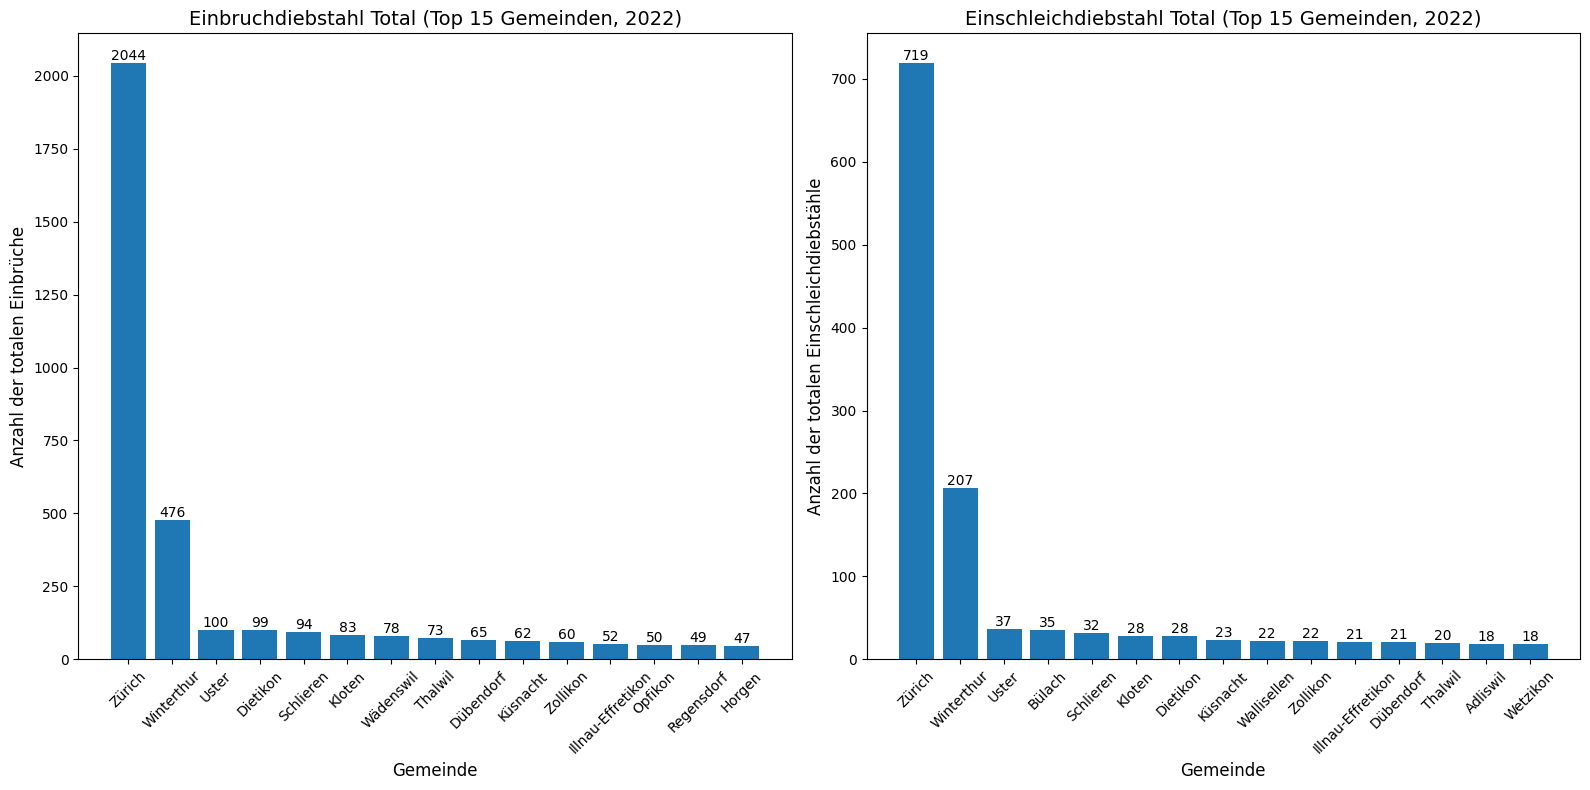

In [185]:
import matplotlib.pyplot as plt

# Filtern der Daten für das Jahr 2022
df_2022 = df_unique[df_unique['Jahr'] == 2022]

# Sortieren nach Einbruchdiebstahl_Total und Einschleichdiebstahl_Total, um die Top 15 Gemeinden zu finden
df_sorted_by_einbruch = df_2022.sort_values(by='Einbruchdiebstahl_Total', ascending=False).head(15)
df_sorted_by_einschleich = df_2022.sort_values(by='Einschleichdiebstahl_Total', ascending=False).head(15)

# Gemeinden mit den höchsten Einbruchszahlen für Einbruchdiebstahl_Total und Einschleichdiebstahl_Total
top_einbruch_gemeinden = df_sorted_by_einbruch['Gemeindename']
top_einschleich_gemeinden = df_sorted_by_einschleich['Gemeindename']

# Erstellen der Balkendiagramme
plt.figure(figsize=(16, 8))  # Größere Diagrammgröße

# Balkendiagramm für Einbruchdiebstahl_Total
plt.subplot(1, 2, 1)
bars1 = plt.bar(top_einbruch_gemeinden, df_sorted_by_einbruch['Einbruchdiebstahl_Total'])
plt.xlabel('Gemeinde', fontsize=12)  # Achsenbeschriftung mit kleinerer Schrift
plt.ylabel('Anzahl der totalen Einbrüche', fontsize=12)  # Achsenbeschriftung mit kleinerer Schrift
plt.title('Einbruchdiebstahl Total (Top 15 Gemeinden, 2022)', fontsize=14)  # Titel mit größerer Schrift
plt.xticks(rotation=45, fontsize=10)  # Achsenbeschriftungen mit kleinerer Schrift und Rotation

# Labels über den Balken hinzufügen
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

# Balkendiagramm für Einschleichdiebstahl_Total
plt.subplot(1, 2, 2)
bars2 = plt.bar(top_einschleich_gemeinden, df_sorted_by_einschleich['Einschleichdiebstahl_Total'])
plt.xlabel('Gemeinde', fontsize=12)  # Achsenbeschriftung mit kleinerer Schrift
plt.ylabel('Anzahl der totalen Einschleichdiebstähle', fontsize=12)  # Achsenbeschriftung mit kleinerer Schrift
plt.title('Einschleichdiebstahl Total (Top 15 Gemeinden, 2022)', fontsize=14)  # Titel mit größerer Schrift
plt.xticks(rotation=45, fontsize=10)  # Achsenbeschriftungen mit kleinerer Schrift und Rotation

# Labels über den Balken hinzufügen
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


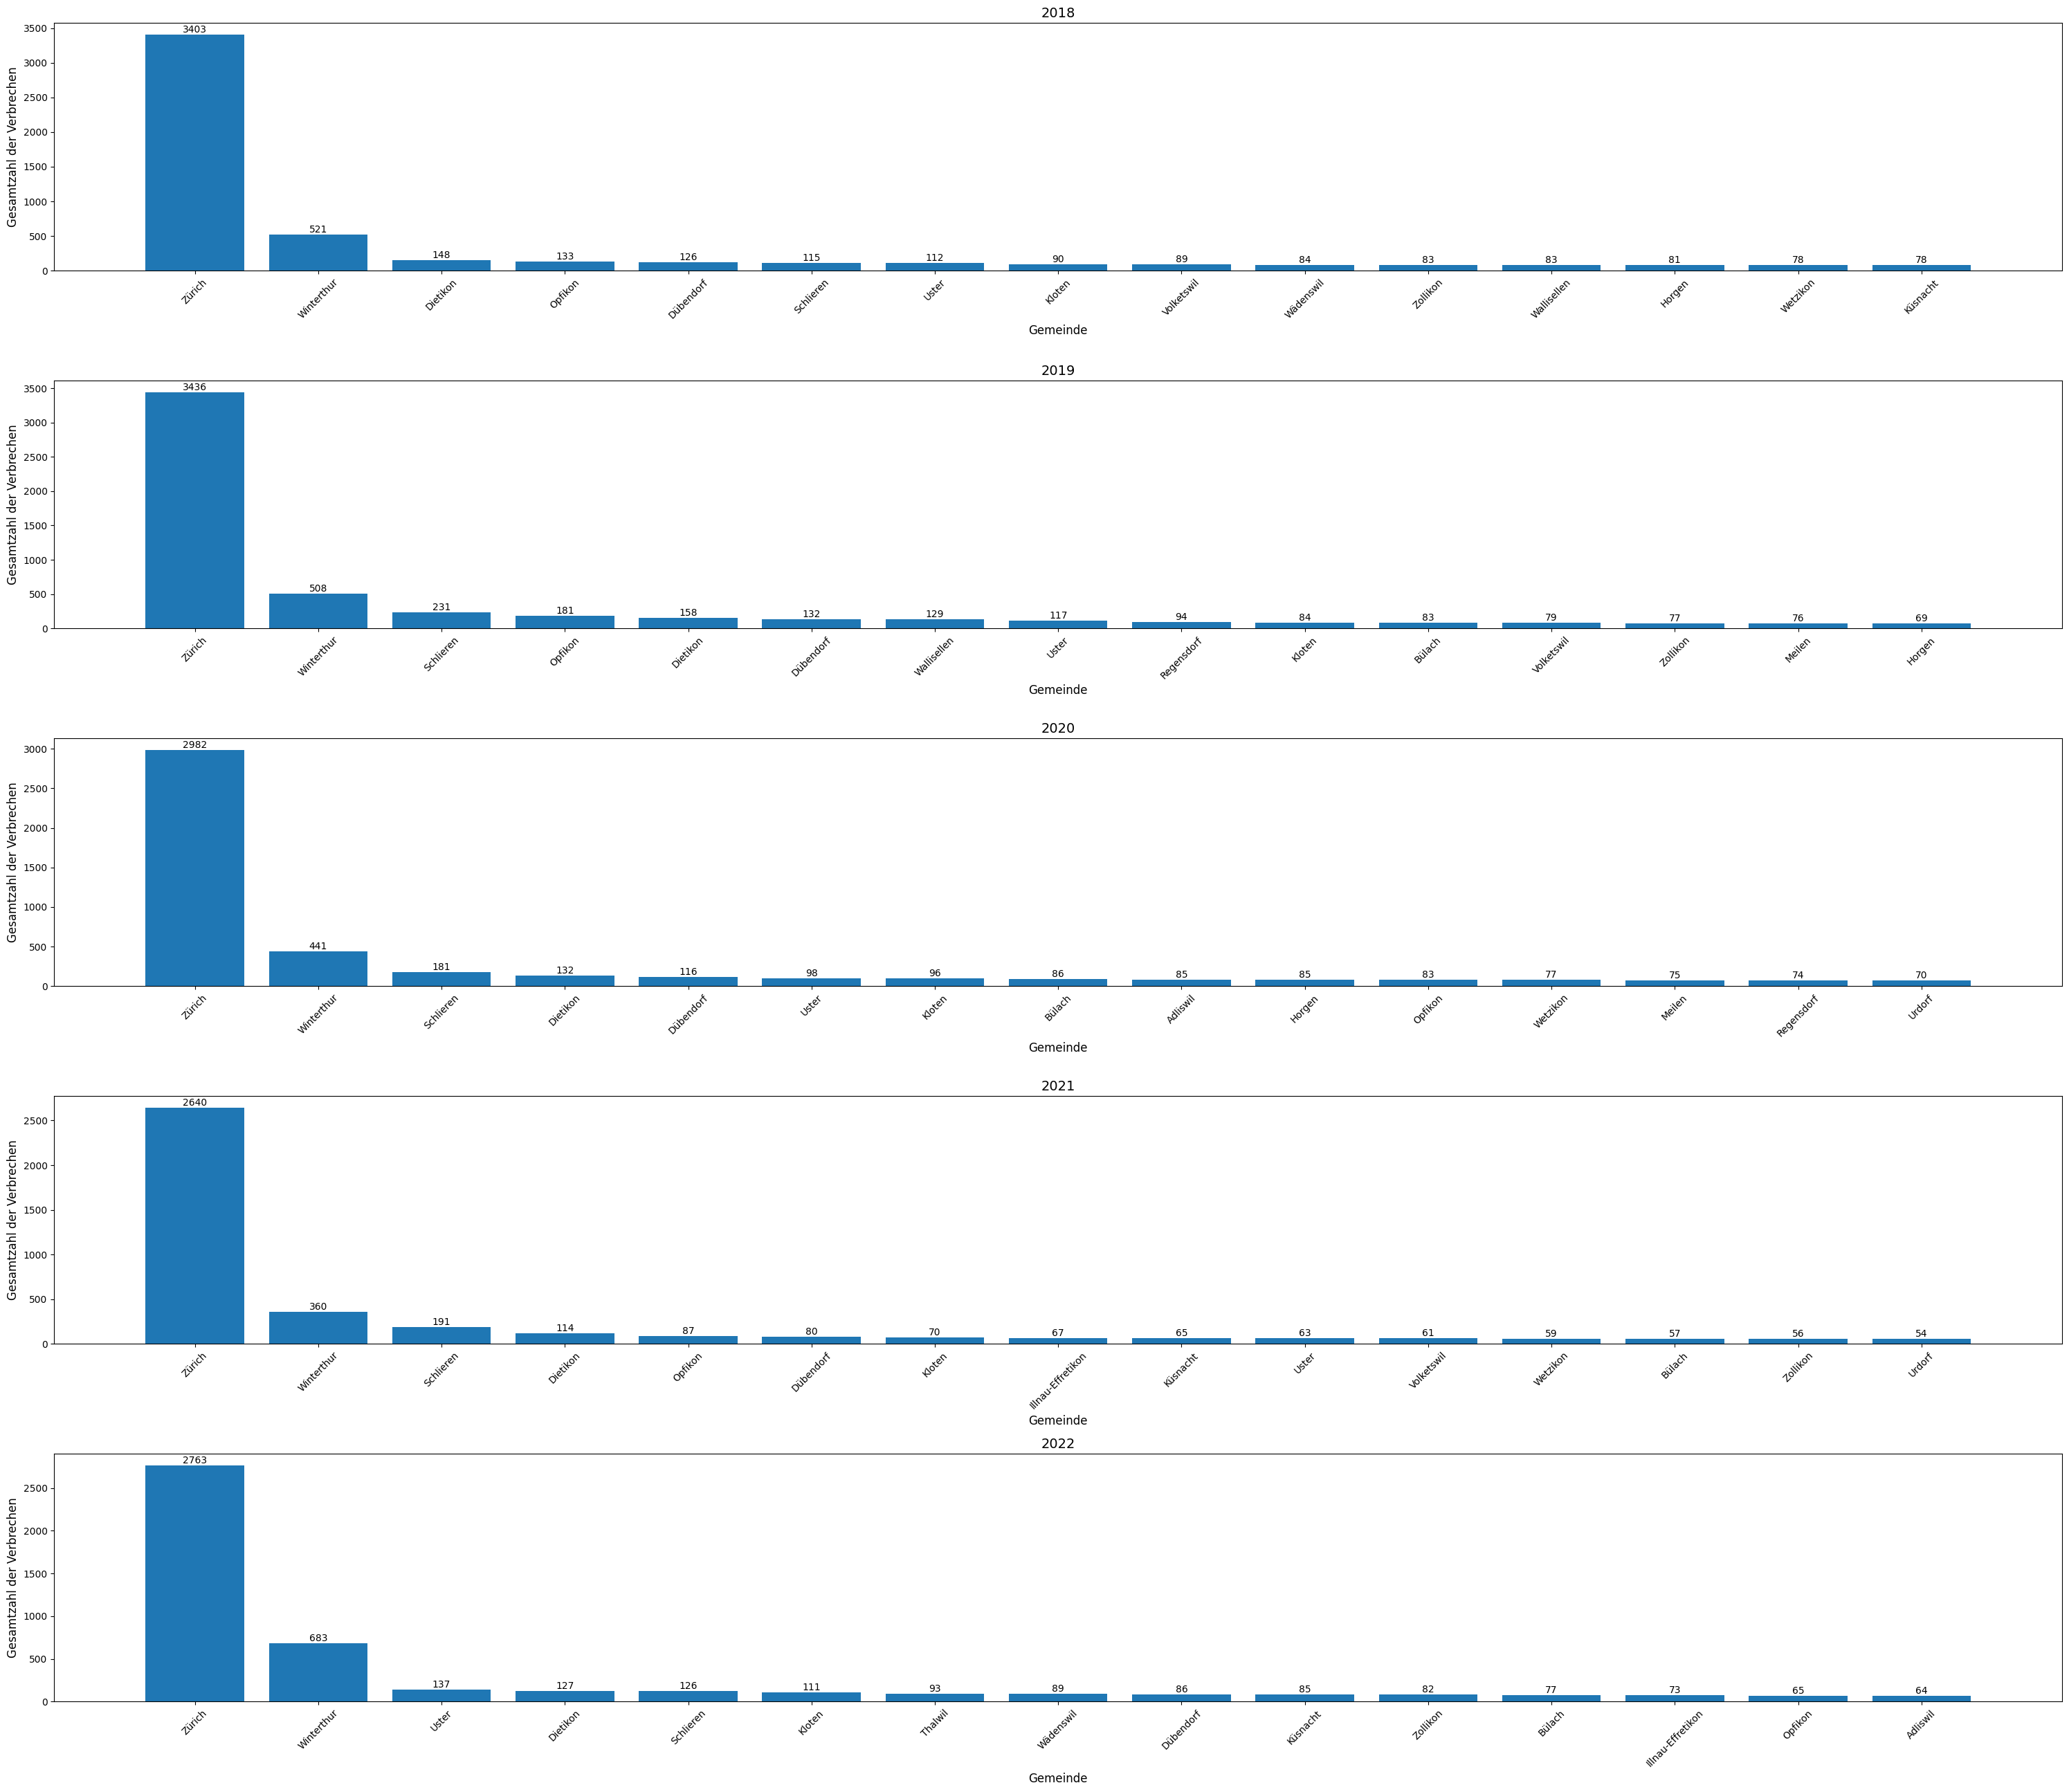

In [186]:
import matplotlib.pyplot as plt

# Filtern der Daten für die letzten 5 Jahre
df_last_5_years = df_unique[df_unique['Jahr'] >= df_unique['Jahr'].max() - 4]

# Sortieren nach Einbruchdiebstahl_Total + Einschleichdiebstahl_Total, um die Top 15 Gemeinden zu finden
df_sorted_by_crime = df_last_5_years.assign(
    total_crime=lambda x: x['Einbruchdiebstahl_Total'] + x['Einschleichdiebstahl_Total']
).sort_values(by='total_crime', ascending=False)

# Erstellen der Histogramme
plt.figure(figsize=(30, 26))  # Ändere die Höhe des gesamten Diagramms, um Platz für alle Grafiken zu schaffen

for i, year in enumerate(range(df_sorted_by_crime['Jahr'].min(), df_sorted_by_crime['Jahr'].max() + 1)):
    plt.subplot(5, 1, i+1)
    data_year = df_sorted_by_crime[df_sorted_by_crime['Jahr'] == year].head(15)  # Wähle die Top-15-Gemeinden für jedes Jahr aus
    bars = plt.bar(data_year['Gemeindename'], data_year['total_crime'])
    plt.title(f'{year}', fontsize=14)
    plt.xlabel('Gemeinde', fontsize=12)
    plt.ylabel('Gesamtzahl der Verbrechen', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    
    # Labels über den Balken hinzufügen
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

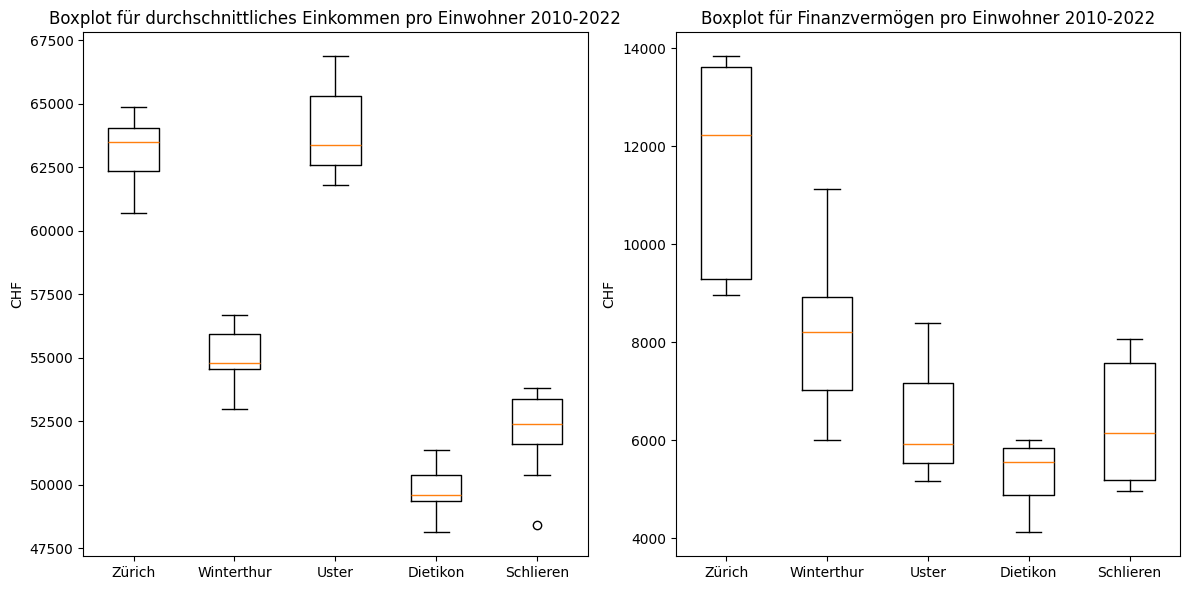

In [187]:
import matplotlib.pyplot as plt

# Top 5 Gemeinden auswählen
top_5_gemeinden = ['Zürich', 'Winterthur', 'Uster', 'Dietikon', 'Schlieren']

# Daten für das Jahr 2022 filtern
df_2022_top5 = df_unique[(df_unique['Gemeindename'].isin(top_5_gemeinden))]

# Einkommens- und Vermögensdaten extrahieren
income_data = [df_2022_top5[df_2022_top5['Gemeindename'] == gemeinde]['durchschnittliches_steuerbares_Einkommen_pro_Einwohner'] for gemeinde in top_5_gemeinden]
wealth_data = [df_2022_top5[df_2022_top5['Gemeindename'] == gemeinde]['Finanzvermoegen_pro_Einwohner'] for gemeinde in top_5_gemeinden]

# Boxplots erstellen
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Erste Unterteilung für das Einkommens-Boxplot
plt.boxplot(income_data, labels=top_5_gemeinden)
plt.title('Boxplot für durchschnittliches Einkommen pro Einwohner 2010-2022')
plt.ylabel('CHF')

plt.subplot(1, 2, 2)  # Zweite Unterteilung für das Vermögens-Boxplot
plt.boxplot(wealth_data, labels=top_5_gemeinden)
plt.title('Boxplot für Finanzvermögen pro Einwohner 2010-2022')
plt.ylabel('CHF')

plt.tight_layout()
plt.show()

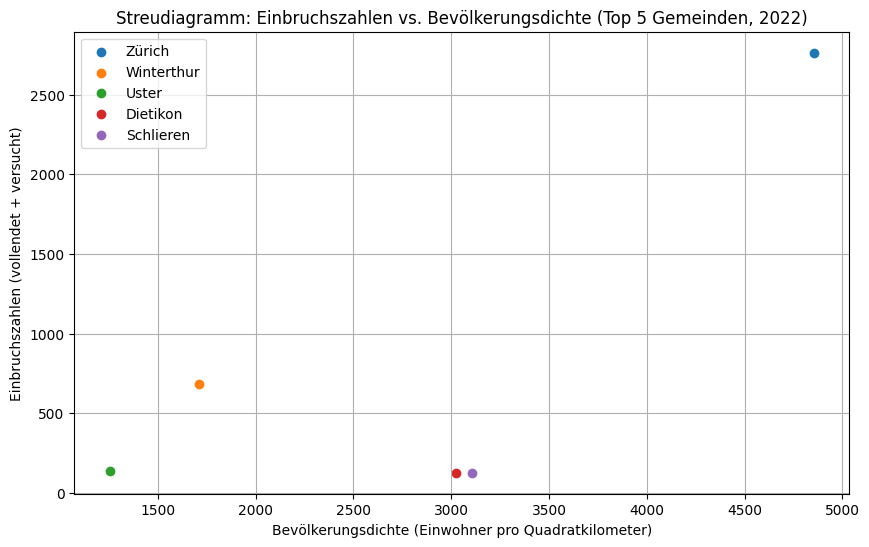

In [188]:
import matplotlib.pyplot as plt

# Filtern der Daten für das Jahr 2022 und die top 5 Gemeinden
top5_gemeinden = ['Zürich', 'Winterthur', 'Uster', 'Dietikon', 'Schlieren']
df_top5_2022 = df_unique[(df_unique['Gemeindename'].isin(top5_gemeinden)) & (df_unique['Jahr'] == 2022)]

# Streudiagramm erstellen
plt.figure(figsize=(10, 6))
for gemeinde in top5_gemeinden:
    data = df_top5_2022[df_top5_2022['Gemeindename'] == gemeinde]
    plt.scatter(data['Einwohner_pro_Quadratkilometer'], data['Einbruchdiebstahl_Total'] + data['Einschleichdiebstahl_Total'], label=gemeinde)

# Diagramm beschriften
plt.title('Streudiagramm: Einbruchszahlen vs. Bevölkerungsdichte (Top 5 Gemeinden, 2022)')
plt.xlabel('Bevölkerungsdichte (Einwohner pro Quadratkilometer)')
plt.ylabel('Einbruchszahlen (vollendet + versucht)')
plt.legend()
plt.grid(True)
plt.show()

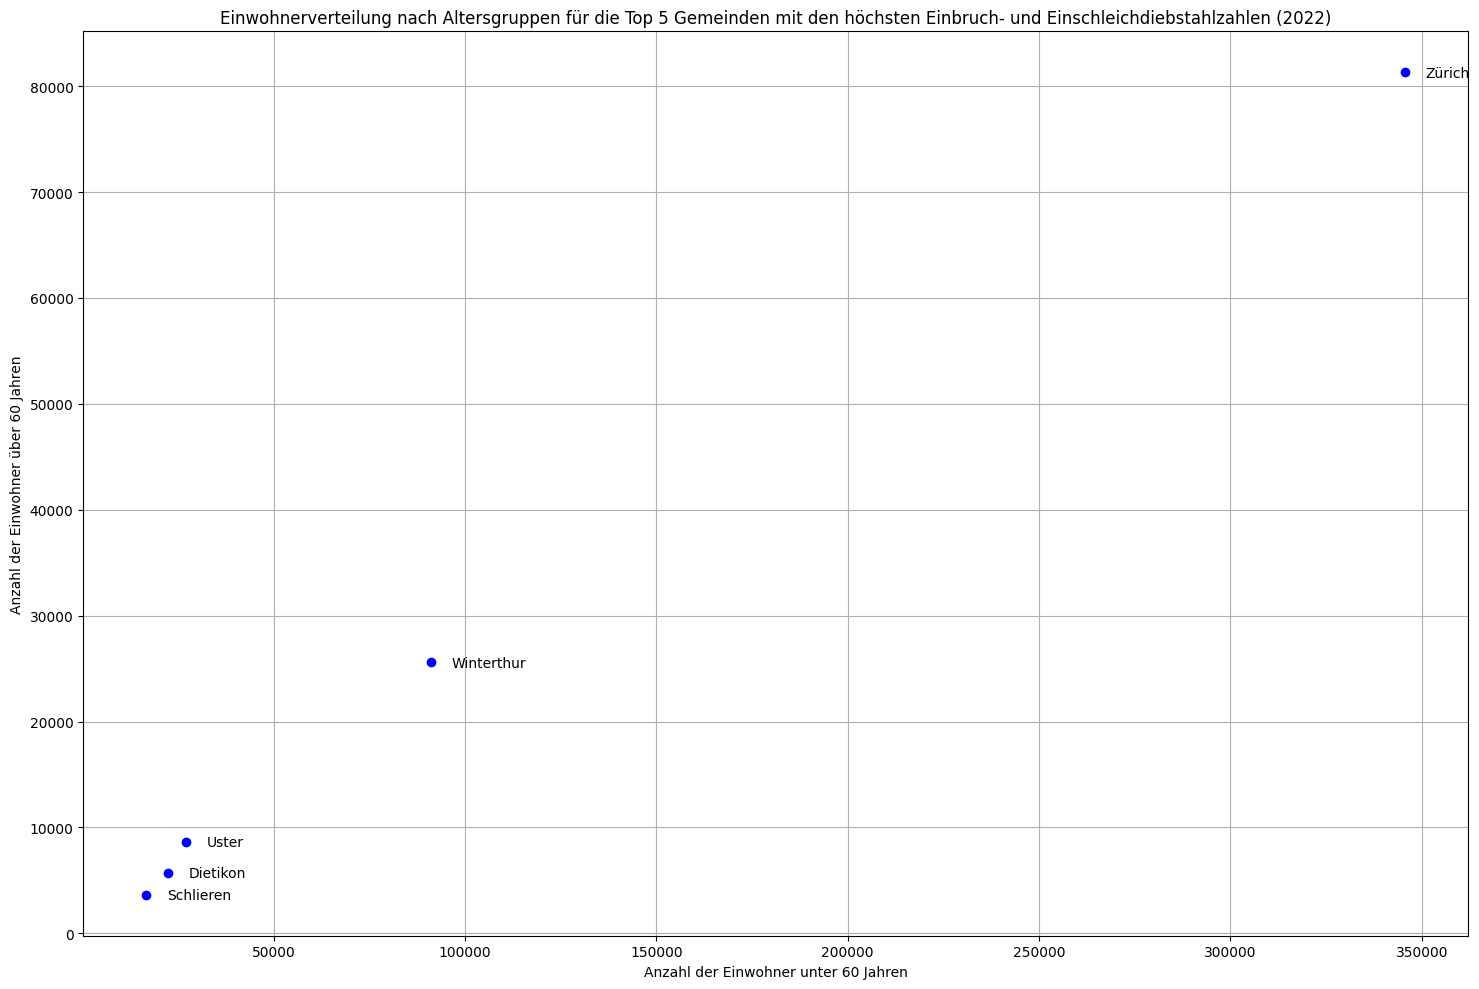

In [189]:
import matplotlib.pyplot as plt

# Filtern der Daten für das Jahr 2022
df_2022 = df_unique[df_unique['Jahr'] == 2022]

# Auswahl der Top 5 Gemeinden mit den höchsten Einbruch- und Einschleichdiebstahlzahlen
top_5_communities = df_2022.nlargest(5, ['Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total'])
top_5_communities = top_5_communities[['Gemeindename', 'Einwohner 0-14 Jahre alt', 'Einwohner 15-29 Jahre alt', 
                                       'Einwohner 30-44 Jahre alt', 'Einwohner 45-59 Jahre alt', 
                                       'Einwohner 60-74 Jahre alt', 'Einwohner 75-89 Jahre alt', 
                                       'Einwohner 90-104 Jahre alt']]

# Berechnung der Summe der Einwohner über 60 Jahre und unter 60 Jahren
top_5_communities['Einwohner über 60 Jahre'] = top_5_communities[['Einwohner 60-74 Jahre alt', 'Einwohner 75-89 Jahre alt', 
                                                                 'Einwohner 90-104 Jahre alt']].sum(axis=1)
top_5_communities['Einwohner unter 60 Jahre'] = top_5_communities[['Einwohner 0-14 Jahre alt', 'Einwohner 15-29 Jahre alt', 
                                                                   'Einwohner 30-44 Jahre alt', 'Einwohner 45-59 Jahre alt']].sum(axis=1)

# Erstellen des Streudiagramms
plt.figure(figsize=(15, 10))

plt.scatter(top_5_communities['Einwohner unter 60 Jahre'], top_5_communities['Einwohner über 60 Jahre'], color='blue')

# Beschriftung der Punkte mit den Gemeindenamen
for i, txt in enumerate(top_5_communities['Gemeindename']):
    plt.annotate(txt, (top_5_communities['Einwohner unter 60 Jahre'].iloc[i], top_5_communities['Einwohner über 60 Jahre'].iloc[i]),
                 xytext=(15, -3), textcoords='offset points')  # Verschiebung der Labels um 5 Punkte nach rechts und oben

plt.xlabel('Anzahl der Einwohner unter 60 Jahren')
plt.ylabel('Anzahl der Einwohner über 60 Jahren')
plt.title('Einwohnerverteilung nach Altersgruppen für die Top 5 Gemeinden mit den höchsten Einbruch- und Einschleichdiebstahlzahlen (2022)')

plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_1764/2538104496.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Einkommensgruppe'] = df_2022.apply(income_group, axis=1)


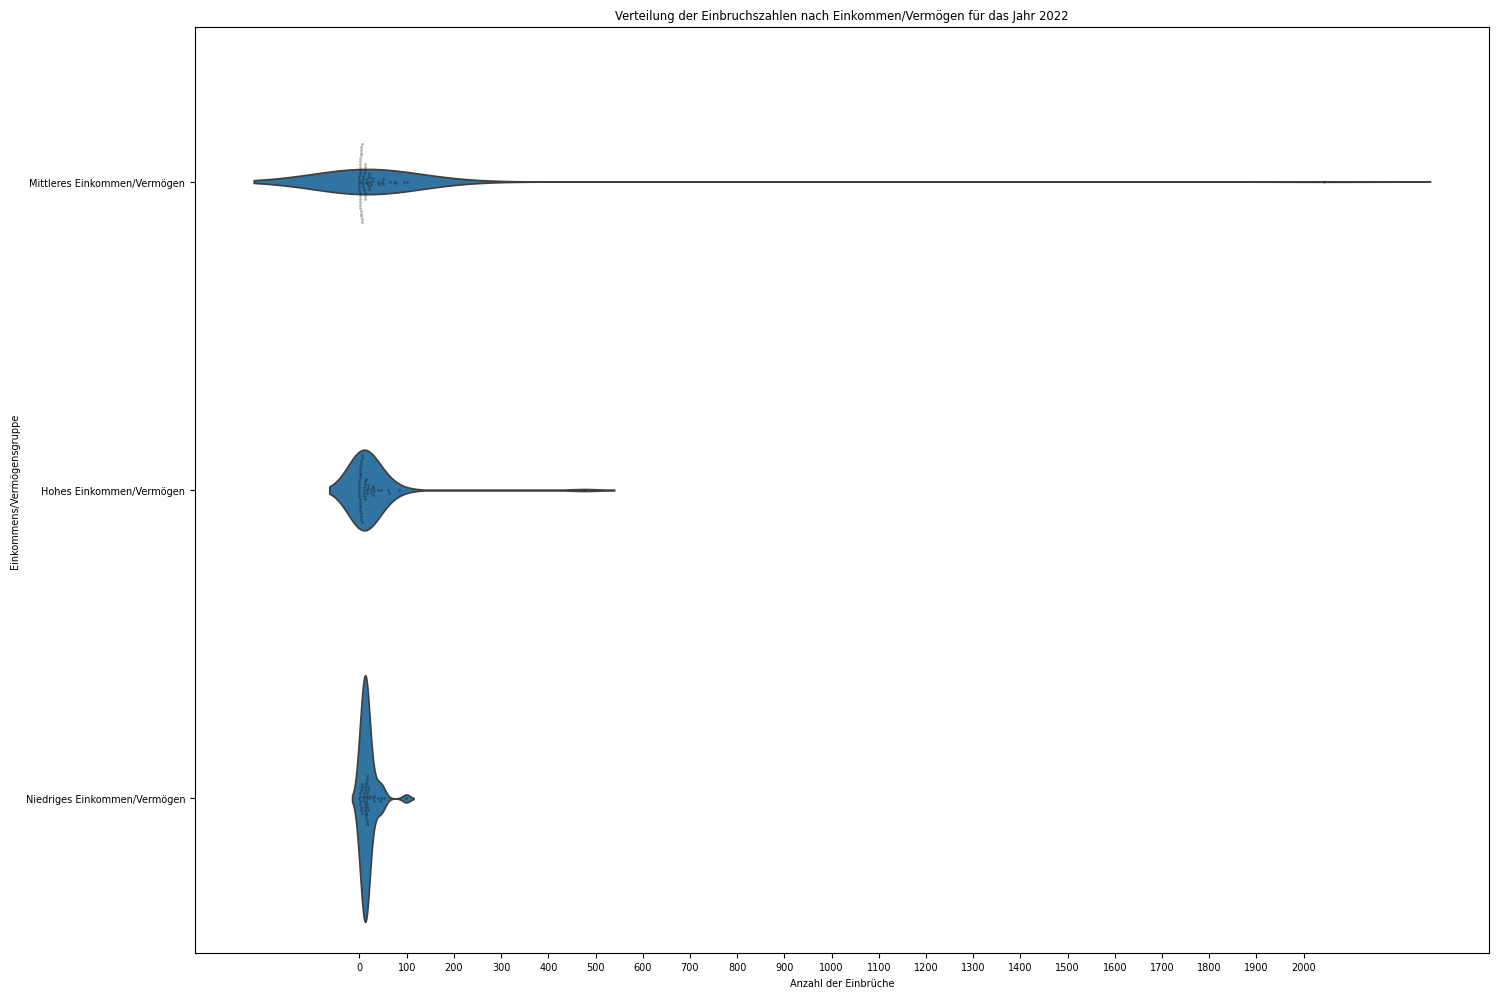

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

# Annahme: df_unique ist dein DataFrame mit den Daten für das Jahr 2022

# Filtern der Daten für das Jahr 2022
df_2022 = df_unique[df_unique['Jahr'] == 2022]

# Berechnen der Quantile für die Gruppierung
quantiles = df_2022['Finanzvermoegen_pro_Einwohner'].quantile([0.3, 0.7])  # 30% und 70% Quantile

# Funktion zur Gruppierung basierend auf den Quantilen
def income_group(row):
    if row['Finanzvermoegen_pro_Einwohner'] <= quantiles.iloc[0]:
        return 'Niedriges Einkommen/Vermögen'
    elif row['Finanzvermoegen_pro_Einwohner'] <= quantiles.iloc[1]:
        return 'Mittleres Einkommen/Vermögen'
    else:
        return 'Hohes Einkommen/Vermögen'

# Neue Spalte für die Einkommens/Vermögensgruppe erstellen
df_2022['Einkommensgruppe'] = df_2022.apply(income_group, axis=1)

# Größe der Plots anpassen und Schriftgröße reduzieren
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 7})  # Schriftgröße reduzieren

# Erstellen des Violinplots
sns.violinplot(x='Einbruchdiebstahl_Total', y='Einkommensgruppe', data=df_2022, inner=None)
sns.swarmplot(x='Einbruchdiebstahl_Total', y='Einkommensgruppe', data=df_2022, color='k', alpha=0.3, size=2)  # Größe der Marker reduzieren

# Benutzerdefinierte Tick-Marken für die x-Achse
max_value = df_2022['Einbruchdiebstahl_Total'].max()
xticks = np.arange(0, max_value + 1, 100)  # Erstellt einen Bereich von 0 bis zum maximalen Wert mit Schritten von 50
plt.xticks(xticks)

plt.xlabel('Anzahl der Einbrüche')
plt.ylabel('Einkommens/Vermögensgruppe')
plt.title('Verteilung der Einbruchszahlen nach Einkommen/Vermögen für das Jahr 2022')
plt.tight_layout()
plt.show()


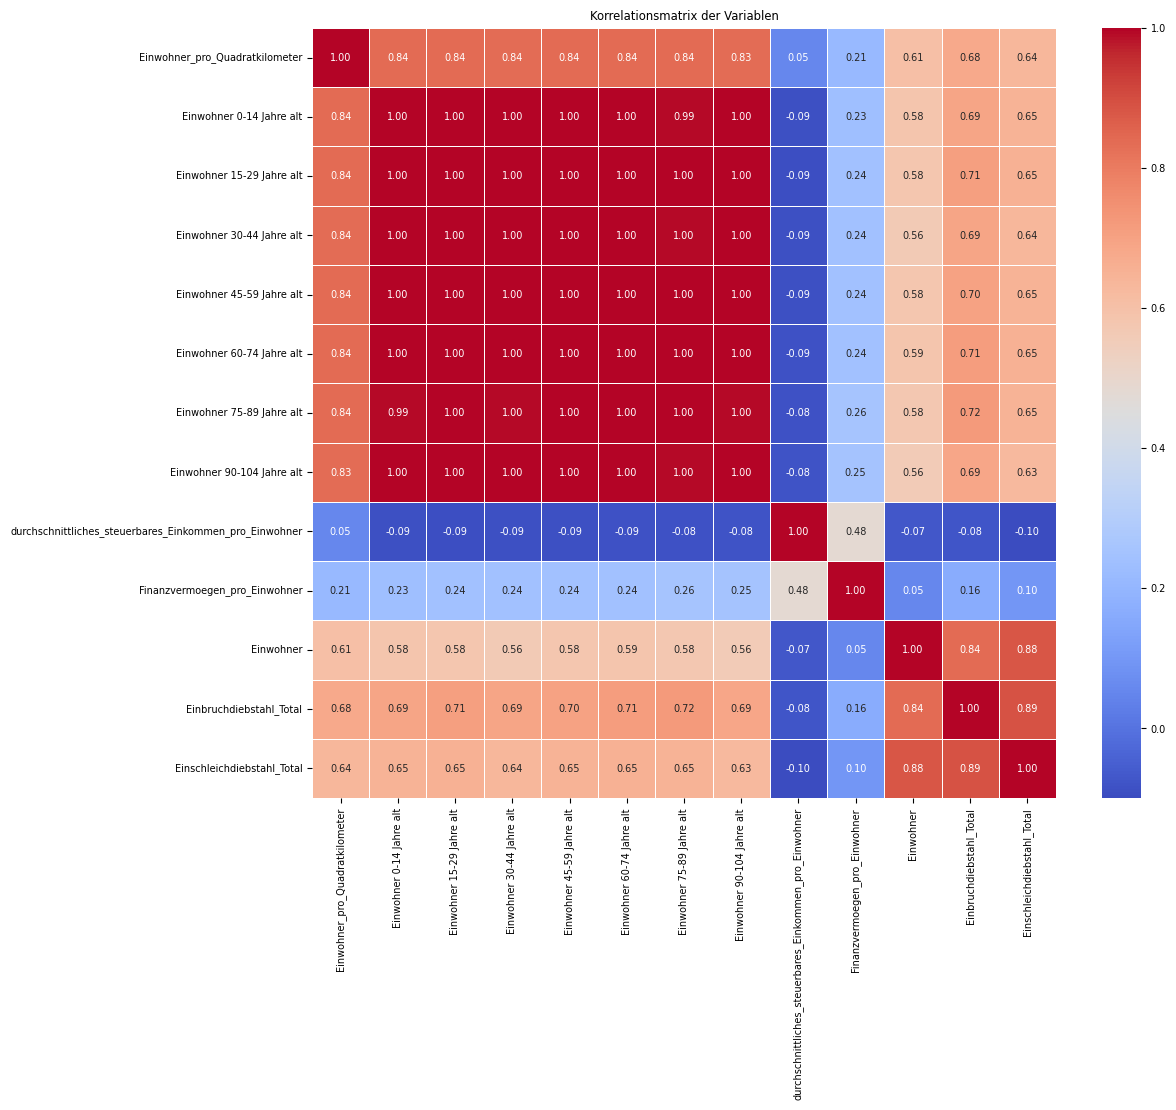

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

# Auswahl der numerischen Spalten
numeric_columns = df[['Einwohner_pro_Quadratkilometer', 'Einwohner 0-14 Jahre alt', 'Einwohner 15-29 Jahre alt',
                      'Einwohner 30-44 Jahre alt', 'Einwohner 45-59 Jahre alt', 'Einwohner 60-74 Jahre alt',
                      'Einwohner 75-89 Jahre alt', 'Einwohner 90-104 Jahre alt',
                      'durchschnittliches_steuerbares_Einkommen_pro_Einwohner', 'Finanzvermoegen_pro_Einwohner',
                      'Einwohner', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total',
                    ]]

# Berechnung der Korrelationen
correlation_matrix = numeric_columns.corr()

# Erstellen der Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der Variablen')
plt.show()


1. Durchschnittliches steuerbares Einkommen pro Einwohner:
   - Korrelation von -0.08 mit Einbruchdiebstahl Total: Es besteht eine leichte negative Korrelation zwischen dem durchschnittlichen steuerbaren Einkommen pro Einwohner und der Gesamtzahl der Einbruchdiebstähle. Das bedeutet, dass Gemeinden mit höheren Einkommen tendenziell weniger Einbrüche haben.
   - Korrelation von -0.10 mit Einschleichdiebstahl Total: Die Korrelation ist schwach negativ, was darauf hinweist, dass es eine geringfügige Tendenz gibt, dass Gemeinden mit höherem Einkommen tendenziell weniger Einschleichdiebstähle haben.

2. Finanzvermögen pro Einwohner:
   - Korrelation von 0.16 mit Einbruchdiebstahl Total: Es besteht eine schwache positive Korrelation zwischen dem Finanzvermögen pro Einwohner und der Gesamtzahl der Einbruchdiebstähle. Dies bedeutet, dass Gemeinden mit höherem Finanzvermögen tendenziell etwas mehr Einbrüche haben könnten.
   - Korrelation von 0.10 mit Einschleichdiebstahl Total: Die Korrelation ist ebenfalls schwach positiv, was darauf hinweist, dass Gemeinden mit höherem Finanzvermögen tendenziell etwas mehr Einschleichdiebstähle haben könnten.

3. Einwohner:
   - Korrelation von 0.84 mit Einbruchdiebstahl Total: Es besteht eine starke positive Korrelation zwischen der Gesamteinwohnerzahl einer Gemeinde und der Gesamtzahl der Einbruchdiebstähle. Das bedeutet, dass Gemeinden mit einer höheren Bevölkerung tendenziell mehr Einbrüche haben.
   - Korrelation von 0.88 mit Einschleichdiebstahl Total: Die Korrelation ist ebenfalls stark positiv, was darauf hinweist, dass Gemeinden mit einer höheren Bevölkerung tendenziell mehr Einschleichdiebstähle haben.